# Importing

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, Image, Javascript
from scipy.stats import scoreatpercentile, percentileofscore
import sys
import seaborn as sns
import matplotlib.pyplot as plt
%autosave 60
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 20)
plt.rcParams['figure.figsize'] = [10, 5]

Autosaving every 60 seconds


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

In [3]:
# MYUTILS_PATH = '/Users/amits/Projects/_MyUtils'
# if MYUTILS_PATH not in sys.path:
#     sys.path.append(MYUTILS_PATH)
# from pd_helpers import describe_field
# import functools
# report = functools.partial(describe_field, plot=True)


# Pre-task

### finding the score to beat

Get all submissions, give each team the maximal submission score. 
Remove scores smaller than the gender submission. 
Remove socres of 1.00 since those are cheats. 
Take the 90th percentile. 

The score to beat is:  0.79904 
------------------------------


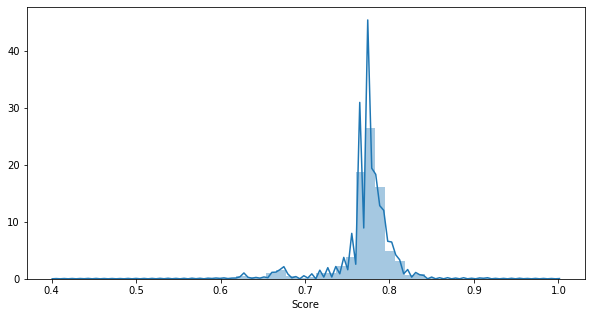

In [4]:
submissions = pd.read_csv('titanic-publicleaderboard.csv')
sub_max_scores = submissions.groupby('TeamId')['Score'].agg('max')
sub_max_scores = sub_max_scores[(sub_max_scores>0.4) & (sub_max_scores<1)]

score_to_beat = scoreatpercentile(sub_max_scores, 90)
print('The score to beat is: ', score_to_beat, '\n' + '-'*30)
sns.distplot(sub_max_scores);

# Loading the data

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
CLASS_LABEL = 'Survived'
data = pd.concat([train, test], axis=0).reset_index(drop=True)
data_p = data.copy()

In [6]:
data_p.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Find missing values

In [7]:
(data_p.isna().sum().sort_values(ascending=False).replace(0, np.nan).dropna() / data_p.shape[0] * 100).to_frame('NaN %').T

,Cabin,Survived,Age,Embarked,Fare
NaN %,77.463713,31.932773,20.091673,0.152788,0.076394


# EDA - A

In [8]:
print(*train.columns, sep='\n')

PassengerId
Survived
Pclass
Name
Sex
Age
SibSp
Parch
Ticket
Fare
Cabin
Embarked


define dummy columns to be converted to numerical later on

In [9]:
dummy_columns = []
dummy_columns.append('Pclass')

# Column by column extraction

We go column by column and extract the features we can.

### Name column:
#### Extract the <ins>title</ins>, <ins>nickname</ins> and <ins>name inside parenthesis</ins>.

There is lot's to be done with the name column since it contains lots of information. We can find spouses using this column, and we can find the title of the person, and the nickname. 
In what follows I've extracted the title, nickname, name inside parenthesis, and clean_name (which is the name after removing all the above).

In [10]:
def get_title(name):
    import re
    match = re.search('\w{2,}\.\s', name)
    if match is None:
        return None
    else:
        return match.group()

In [11]:
def get_nickname(name):
    import re
    match = re.search('"[\w\s]{2,}"', name)
    if match is None:
        return None
    else:
        return match.group()

In [12]:
def get_pname(name):
    import re
    match = re.search('\([\w\s]{2,}\)', name)
    if match is None:
        return None
    else:
        return match.group()

In [13]:
data_p['Title'] = data['Name'].apply(get_title)
data_p['Nickname'] = data['Name'].apply(get_nickname)
data_p['Pname'] =  data['Name'].apply(get_pname)
data_p['CleanName'] = data_p.fillna('&&&').apply(lambda x: x['Name']
                                  .replace(x['Nickname'], ' ')
                                  .replace(x['Title'], ' ')
                                  .replace(x['Pname'], ' ')
                                  .replace('  ', ' ').replace('  ', ' ').replace('( )','').strip(', ')
                                  , axis=1)
data_p['CleanNameShort'] = data_p['CleanName'].apply(lambda x: ' '.join(x.split()[:2]))

data_p['Title'] = data_p['Title'].str.strip(' .')

Find if a person is unmarried by their title

In [14]:
UNMARRIED_TITLES = ['Mlle', 'Master', 'Miss']
data_p['Title_Unmarried'] = data_p['Title'].apply(lambda x: x in UNMARRIED_TITLES)

Group rare titles into one "Rare" title

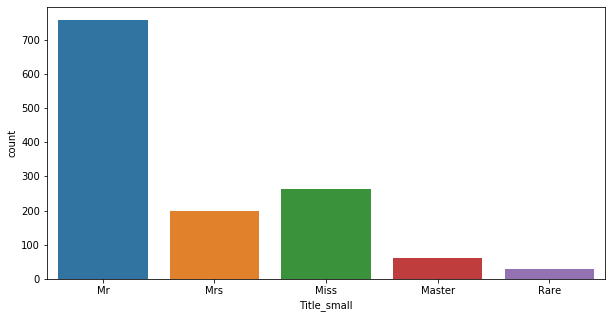

In [15]:
data_p['Title_small'] = data_p['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 
                                                 'Jonkheer', 'Dona'], 'Rare')
data_p['Title_small'] = data_p['Title_small'].replace('Mlle', 'Miss')
data_p['Title_small'] = data_p['Title_small'].replace('Ms', 'Miss')
data_p['Title_small'] = data_p['Title_small'].replace('Mme', 'Mrs')
sns.countplot(data_p['Title_small']);

### SibSp Column:
#### Extract <ins>spouse onboard </ins> and <ins>siblings onboard </ins> 

The SibSp column specifies the number of spouses/siblings onboard for each person. By using the name we can separate the two and get two columns - one for spouse onboard and one for siblings onboard. 
We find spouses by having the same clean name as well as both unmarried, as well as of opposite sex.

In [16]:
data_p['Sp_onboard'] = ((data_p.groupby(['CleanNameShort','Title_Unmarried'])['CleanNameShort'].transform('count')==2) \
                        &(data_p.groupby(['CleanNameShort','Title_Unmarried'])['Sex'].transform('nunique')>1)).astype(int)
data_p['Sib_onboard'] = data_p['SibSp'] - data_p['Sp_onboard']
data_p.loc[data_p['Sib_onboard']<0,'Sib_onboard'] = 0

### Parch Column:
#### Extract <ins>children onboard </ins> and  <ins>parent onboard</ins>

- First group each party by the ticket. 
- For each passenger count the number of passengers that could've been his/her child (more than 13 years younger than said passenger).
- The number of children onboard of a passenger is the minimum between the Parch column and the number of possible children. 
- The number of parents onboard of a passenger is then Parch (parents + children onboard) minus the number of children ob board.

In [17]:
MINIMAL_YEARS_FOR_PARENT = 13
def group_pa_pos(x):
    x_copy = x.copy()
    result = x.copy()
    for i, y in enumerate(x_copy):
        if pd.isna(y):
            result.iloc[i] = len(x_copy) - 1
        else:
            result.iloc[i] = (x_copy.fillna(80) > (y+MINIMAL_YEARS_FOR_PARENT)).sum()
    return result

def group_ch_pos(x):
    x_copy = x.copy()
    result = x.copy()
    for i, y in enumerate(x_copy):
        if pd.isna(y):
            result.iloc[i] = len(x_copy)-1
        else:
            result.iloc[i] = (x_copy.fillna(1) < (y-MINIMAL_YEARS_FOR_PARENT)).sum()
    return result

data_p['_ch_pos'] = data_p.groupby(['Ticket'])['Age'].transform(group_ch_pos)
data_p['Ch_onboard'] = data_p.apply(lambda x: min(x[['_ch_pos', 'Parch']]), axis=1)
data_p['Pa_onboard'] = data_p['Parch'] - data_p['Ch_onboard']
data_p['group_size'] = data_p.groupby(['Ticket'])['Ticket'].transform('count')
data_p['family_size'] = data_p['SibSp'] + data_p['Parch'] + 1
data_p['is_alone'] = (data_p['family_size'] == 1).astype(int)

Take the Fortune family for example:

In [18]:
data_p.loc[data_p['Ticket']=='19950', 
           ['Title', 'Name', 'Age', 'Sex', 'Parch', '_ch_pos', 'Pa_onboard', 'Ch_onboard', 'Sp_onboard', 'family_size']
          ].sort_values('Age', ascending=False)

,Title,Name,Age,Sex,Parch,_ch_pos,Pa_onboard,Ch_onboard,Sp_onboard,family_size
438,Mr,"Fortune, Mr. Mark",64.0,male,4,4.0,0.0,4.0,1,6
960,Mrs,"Fortune, Mrs. Mark (Mary McDougald)",60.0,female,4,4.0,0.0,4.0,1,6
944,Miss,"Fortune, Miss. Ethel Flora",28.0,female,2,0.0,2.0,0.0,0,6
341,Miss,"Fortune, Miss. Alice Elizabeth",24.0,female,2,0.0,2.0,0.0,0,6
88,Miss,"Fortune, Miss. Mabel Helen",23.0,female,2,0.0,2.0,0.0,0,6
27,Mr,"Fortune, Mr. Charles Alexander",19.0,male,2,0.0,2.0,0.0,0,6


### Survived Column:
#### Extract <ins>group survival rate

This is the first feature that is problematic with leakage. 
The feature is: for each person, look at the other people that came in the group with him (have the same ticket), and compute their average survival rate (not including the data of the person in question). 
It's fine as far as leakage since this is Kaggle, and I actually don't have the labels of the test set. In a real-world situation it might be unrealistic to use this feature. 

In [19]:
OVERALL_SURVIVAL_RATE = data['Survived'].mean()
def group_survival_rate(x, na_value=OVERALL_SURVIVAL_RATE):
    x_copy = x.copy().fillna(na_value)
    result = x_copy.copy()
    people_in_group = result.count()
    if people_in_group == 1:
        return na_value
    for i, y in enumerate(x_copy):
        sum_survived_but_me = x_copy.sum() - y
        result.iloc[i] = sum_survived_but_me / (people_in_group-1.0)
    return result

data_p['group_survival_rate'] = data_p.groupby(['Ticket'])['Survived'].transform(group_survival_rate)

### Sex Column:
Just transform to binary

In [20]:
data_p['Sex_male'] = (data_p['Sex'] == 'male').astype(int)

### Age Column:

An important feature which is 20% empty. Should be filled out by some regression method.

False    0.799083
True     0.200917
Name: Age, dtype: float64


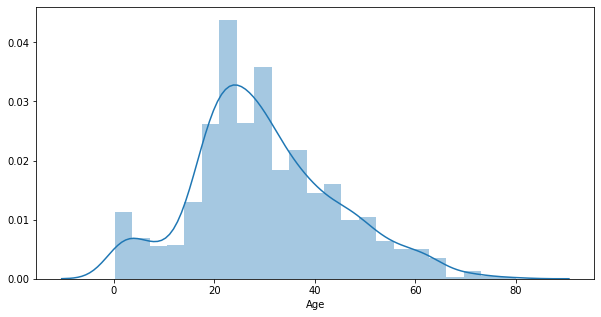

In [21]:
print(data_p['Age'].isna().value_counts(True))
sns.distplot(data_p['Age']);

### Column SibSp:

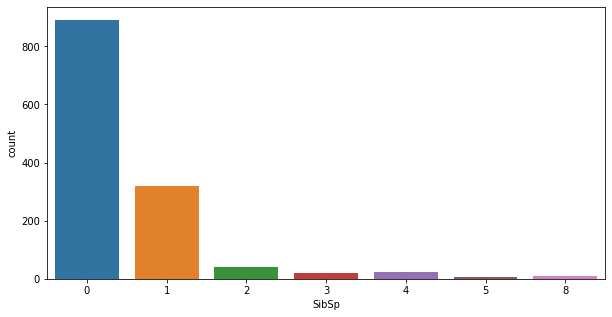

In [22]:
sns.countplot(data_p['SibSp']);

### Column Parch:

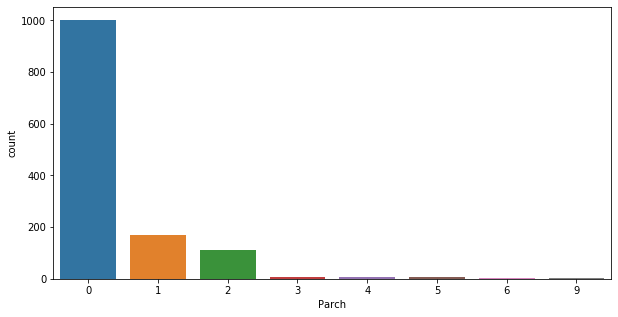

In [23]:
sns.countplot(data_p['Parch']);

### Column Ticket:
#### Extract <ins>ticket format</ins>

We find there are a few formats for the ticket column values. I didn't really dig deeper because the model didn't find the format to be a good feature but it could be interesting to find out how the ticket format is created.

In [24]:
# with help from pd_helpers.get_data_formata
ticket_formats = [
 '([A-Z]\\.){2,3} \\d{4,5}',
 'A[A-Z]?/\\d\\.? \\d{3,5}',
 'A\\.[/ ][25]\\. \\d{4,5}',
 'A\\.?[45]\\. \\d{4,5}',
 'CA\\. 23\\d{2}',
 'LINE',
 'SC/AH Basle 541',
 'SC/A\\.3 \\d{3,4}',
 'SC/Paris 21\\d3',
 'SO?TON/O[\\s\\.]?[2Q]\\. 3\\d{5,6}',
 'S[A-Z]{1,4}/[A-Z]\\d \\d{5,7}',
 'S\\.[CO]\\./[AP]\\.[4P]\\. \\d{1,5}',
 'W\\./C\\. \\d{4,5}',
 '[A-Z]\\.[A-Z]\\./[A-Z]{2,5} \\d{3,5}',
 '[A-Za-z]{1,2} \\d{4,6}',
 '[A-Z]{1,5}/[A-Z]{1,5} \\d{3,7}',
 '\\d{3,7}']

In [25]:
def replace_with_format(value, formats):
    if pd.isna(value):
        return None
    import re
    for f in formats:
        if re.match('^' + f + '$', value):
            return f
    return None

data_p['Ticket'] = data_p['Ticket'].apply(str)
data_p['Ticket_format'] = data_p['Ticket'].apply(lambda v: replace_with_format(v, ticket_formats))
print(len(data_p[pd.isna(data_p['Ticket_format'])]['Ticket']),'unrecognized formats')
data_p['Ticket_format'].value_counts()

0 unrecognized formats


\d{3,7}                              957
[A-Za-z]{1,2} \d{4,6}                118
([A-Z]\.){2,3} \d{4,5}                69
SO?TON/O[\s\.]?[2Q]\. 3\d{5,6}        38
A[A-Z]?/\d\.? \d{3,5}                 33
[A-Z]{1,5}/[A-Z]{1,5} \d{3,7}         32
W\./C\. \d{4,5}                       14
CA\. 23\d{2}                          12
S\.[CO]\./[AP]\.[4P]\. \d{1,5}         8
[A-Z]\.[A-Z]\./[A-Z]{2,5} \d{3,5}      5
SC/Paris 21\d3                         5
A\.[/ ][25]\. \d{4,5}                  4
LINE                                   4
S[A-Z]{1,4}/[A-Z]\d \d{5,7}            4
A\.?[45]\. \d{4,5}                     4
SC/AH Basle 541                        1
SC/A\.3 \d{3,4}                        1
Name: Ticket_format, dtype: int64

### Fare Column:

There's just one missing value so it seems fair to fix it with an ad-hoc solution.

In [26]:
display(data_p[pd.isna(data['Fare'])])
passenger_1044_probable_fare = data_p[data_p['Pclass'] == data_p.loc[data_p['PassengerId']==1044, 'Pclass'].iloc[0]]['Fare'].dropna().median()
data_p['Fare'] = data_p['Fare'].fillna(passenger_1044_probable_fare)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Nickname,Pname,CleanName,CleanNameShort,Title_Unmarried,Title_small,Sp_onboard,Sib_onboard,_ch_pos,Ch_onboard,Pa_onboard,group_size,family_size,is_alone,group_survival_rate,Sex_male,Ticket_format
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,None,None,"Storey, Thomas","Storey, Thomas",False,Mr,0,0,0.0,0.0,0.0,1,1,1,0.383838,1,"\d{3,7}"


From this graph there seems to be high correlation between Pclass and Fare. Seems that the lower the class the higher the Fare. 

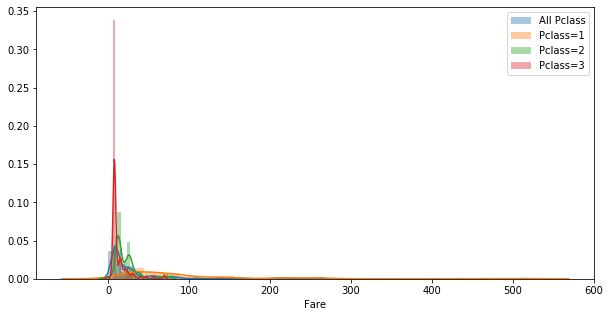

In [27]:
sns.distplot(data['Fare'], label='All Pclass')
for pclass in sorted(data['Pclass'].unique()):
    sns.distplot(data[data['Pclass']==pclass]['Fare'], label=f'Pclass={pclass}')
plt.legend();

From the following graph there seems to be not much correlation between Embarked and Fare. 

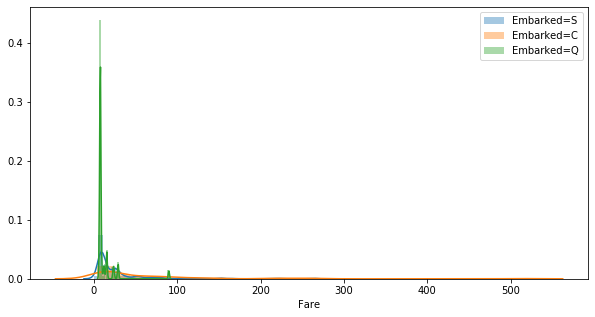

In [28]:
# sns.distplot(data['Embarked'], label='All Pclass')
for eclass in data['Embarked'].dropna().unique():
    sns.distplot(data[data['Embarked']==eclass]['Fare'], label=f'Embarked={eclass}')
plt.legend();

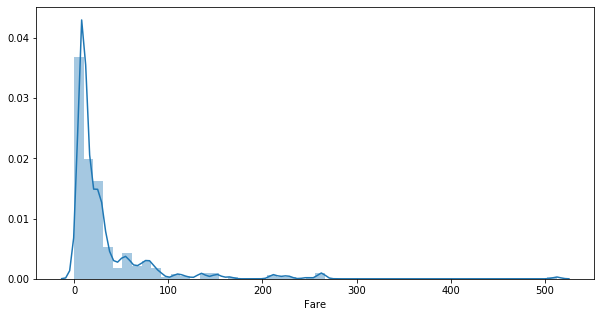

In [29]:
sns.distplot(data_p['Fare']);

### Cabin Column:

We find just 5 cabin formats.

In [30]:
cabin_formats = [
 '([A-Z]\\d{2} ){1,3}[A-Z]\\d{2}',
 'F [A-Z]\\d{2}',
 '[A-Z]',
 '[A-Z]\\d{1,3}']

In [31]:
data_p['Cabin_format'] = data_p['Cabin'].apply(lambda v: replace_with_format(v,  pd.Series(cabin_formats)))

print((data_p[pd.isna(data_p['Cabin_format'])]['Cabin']).count(),'unrecognized formats')
data_p['Cabin_format'].value_counts(True)

0 unrecognized formats


[A-Z]\d{1,3}                    0.840678
([A-Z]\d{2} ){1,3}[A-Z]\d{2}    0.115254
F [A-Z]\d{2}                    0.023729
[A-Z]                           0.020339
Name: Cabin_format, dtype: float64

### Embarked Column:

Again, there are only two missing values. I'll just fill them up with the most common value. 

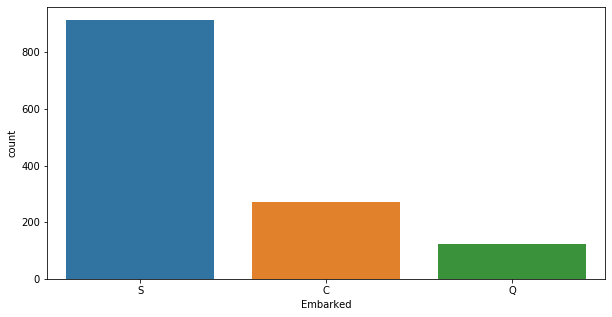

In [32]:
sns.countplot(data_p['Embarked'])
data_p['Embarked'] = data_p['Embarked'].fillna('S')
dummy_columns.append('Embarked')

# Organizing features as numerical

In [33]:
dummy_columns += ['Cabin_format', 'Ticket_format', 'Title_small']
data_features = pd.get_dummies(data_p, columns=list(set(dummy_columns)), drop_first=False)

data_features.drop(columns=['Sex', 'SibSp', 'Parch', 'Ticket', 'Cabin', '_ch_pos', 'Name', 
                            'CleanName', 'CleanNameShort', 'Title'], inplace=True)

data_features['has_Pname'] = pd.notna(data_features['Pname']).astype(int)
data_features['has_Nickname'] = pd.notna(data_features['Nickname']).astype(int)
data_features['Title_Unmarried'] = data_features['Title_Unmarried'].astype(int)
data_features.drop(columns=['Pname', 'Nickname'], inplace=True)

data_features.set_index('PassengerId', inplace=True)

In [34]:
data_features.head()

,Survived,Age,Fare,Title_Unmarried,Sp_onboard,Sib_onboard,Ch_onboard,Pa_onboard,group_size,family_size,is_alone,group_survival_rate,Sex_male,Pclass_1,Pclass_2,Pclass_3,"Cabin_format_([A-Z]\d{2} ){1,3}[A-Z]\d{2}",Cabin_format_F [A-Z]\d{2},Cabin_format_[A-Z],"Cabin_format_[A-Z]\d{1,3}","Ticket_format_([A-Z]\.){2,3} \d{4,5}","Ticket_format_A[A-Z]?/\d\.? \d{3,5}","Ticket_format_A\.?[45]\. \d{4,5}","Ticket_format_A\.[/ ][25]\. \d{4,5}",Ticket_format_CA\. 23\d{2},Ticket_format_LINE,Ticket_format_SC/AH Basle 541,"Ticket_format_SC/A\.3 \d{3,4}",Ticket_format_SC/Paris 21\d3,"Ticket_format_SO?TON/O[\s\.]?[2Q]\. 3\d{5,6}","Ticket_format_S[A-Z]{1,4}/[A-Z]\d \d{5,7}","Ticket_format_S\.[CO]\./[AP]\.[4P]\. \d{1,5}","Ticket_format_W\./C\. \d{4,5}","Ticket_format_[A-Z]\.[A-Z]\./[A-Z]{2,5} \d{3,5}","Ticket_format_[A-Z]{1,5}/[A-Z]{1,5} \d{3,7}","Ticket_format_[A-Za-z]{1,2} \d{4,6}","Ticket_format_\d{3,7}",Embarked_C,Embarked_Q,Embarked_S,Title_small_Master,Title_small_Miss,Title_small_Mr,Title_small_Mrs,Title_small_Rare,has_Pname,has_Nickname
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,22.0,7.2500,0,0,1,0.0,0.0,1,2,0,0.383838,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
2,1.0,38.0,71.2833,0,1,0,0.0,0.0,2,2,0,0.383838,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0
3,1.0,26.0,7.9250,1,0,0,0.0,0.0,1,1,1,0.383838,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,1.0,35.0,53.1000,0,1,0,0.0,0.0,2,2,0,0.000000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0
5,0.0,35.0,8.0500,0,0,0,0.0,0.0,1,1,1,0.383838,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0


Next we remove all columns which are boolean with more than 99% of the same value

In [35]:
for col in data_features.columns:
    if data_features[col].nunique() != 2:
        continue
    if data_features[col].value_counts(True)[0] > 0.99:
        print(f'Dropping column: {col}')
        data_features.drop(columns=col, inplace=True)

Dropping column: Cabin_format_F [A-Z]\d{2}
Dropping column: Cabin_format_[A-Z]
Dropping column: Ticket_format_A\.?[45]\. \d{4,5}
Dropping column: Ticket_format_A\.[/ ][25]\. \d{4,5}
Dropping column: Ticket_format_CA\. 23\d{2}
Dropping column: Ticket_format_LINE
Dropping column: Ticket_format_SC/AH Basle 541
Dropping column: Ticket_format_SC/A\.3 \d{3,4}
Dropping column: Ticket_format_SC/Paris 21\d3
Dropping column: Ticket_format_S[A-Z]{1,4}/[A-Z]\d \d{5,7}
Dropping column: Ticket_format_S\.[CO]\./[AP]\.[4P]\. \d{1,5}
Dropping column: Ticket_format_[A-Z]\.[A-Z]\./[A-Z]{2,5} \d{3,5}


### Fill in <ins>Age</ins> missing values with RandomForestRegressor

In [37]:
all_cols_but_nans = [v for v in data_features.columns if v not in ('Age', 'group_survival_rate', 'Survived')]
age_exists = pd.notna(data_features['Age'])
rfModel_age = RandomForestRegressor()
rfModel_age.fit(data_features[age_exists][all_cols_but_nans], data_features[age_exists]['Age'])

generatedAgeValues = rfModel_age.predict(X = data_features[~age_exists][all_cols_but_nans])
data_features.loc[~age_exists, 'Age'] = generatedAgeValues

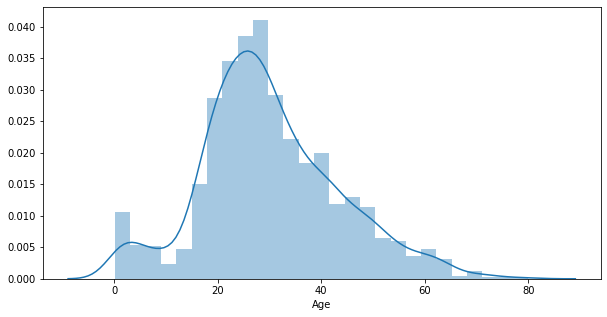

In [38]:
sns.distplot(data_features['Age']);

# Save dataset for model

In [99]:
# data_features.to_pickle('train_and_test_features.pkl')

# Loading features, setting up train, test and CV

In [43]:
data_features = pd.read_pickle('train_and_test_features.pkl')
gender_submission = pd.read_csv('gender_submission.csv').set_index('PassengerId')

# dropping columns which were found to have low feature importance (see bellow)
cols_to_drop = ['Ticket_format_([A-Z]\\.){2,3} \\d{4,5}',
 'Ticket_format_A[A-Z]?/\\d\\.? \\d{3,5}',
 'Ticket_format_SO?TON/O[\\s\\.]?[2Q]\\. 3\\d{5,6}',
 'Ticket_format_W\\./C\\. \\d{4,5}',
 'Ticket_format_[A-Z]{1,5}/[A-Z]{1,5} \\d{3,7}',
 'Ticket_format_[A-Za-z]{1,2} \\d{4,6}','Embarked_Q', 
 'Cabin_format_([A-Z]\\d{2} ){1,3}[A-Z]\\d{2}', 'Pa_onboard', 'Sp_onboard', 'Title_small_Rare', 
 'Ch_onboard',  'Ticket_format_\\d{3,7}', 'Embarked_S']
data_features.drop(columns = (cols_to_drop), inplace=True)
data_features['Pclass'] = data_features['Pclass_3'] * 3 + data_features['Pclass_2'] * 2 + data_features['Pclass_1']
data_features.drop(columns = ['Pclass_1', 'Pclass_2', 'Pclass_3'], inplace=True)
data_features['age*pclass'] = data_features['Age'] * data_features['Pclass']

CLASS_LABEL = 'Survived'
RSEED = np.random.randint(100)

data_features['Age'] = data_features['Age'].fillna(data_features['Age'].mean())
data_features.drop(columns=['group_survival_rate'])
test_set = data_features[pd.isna(data_features[CLASS_LABEL])].copy()
train_set = data_features[pd.notna(data_features[CLASS_LABEL])].copy()

train_set[CLASS_LABEL] = train_set[CLASS_LABEL].astype(int)
labels = np.array(train_set.pop(CLASS_LABEL))
test_set.drop(columns=CLASS_LABEL, inplace=True)

In [44]:
# 20% examples in test data
train, cv, train_labels, cv_labels = train_test_split(train_set,
                                         labels, 
                                         stratify = labels,
                                         test_size = 0.2, 
                                         random_state = RSEED)

# Modeling - On CV

In [45]:
features = list(train.columns)

In [46]:
model = RandomForestClassifier(n_estimators=50, 
                               random_state=RSEED, 
                               max_features = 'sqrt', max_depth=10, bootstrap=True)
# Fit on training data
model.fit(train, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=66, verbose=0,
                       warm_start=False)

In [47]:
# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(cv)
rf_probs = model.predict_proba(cv)[:, 1]

AUC : 0.911
[[103   7]
 [ 17  52]]


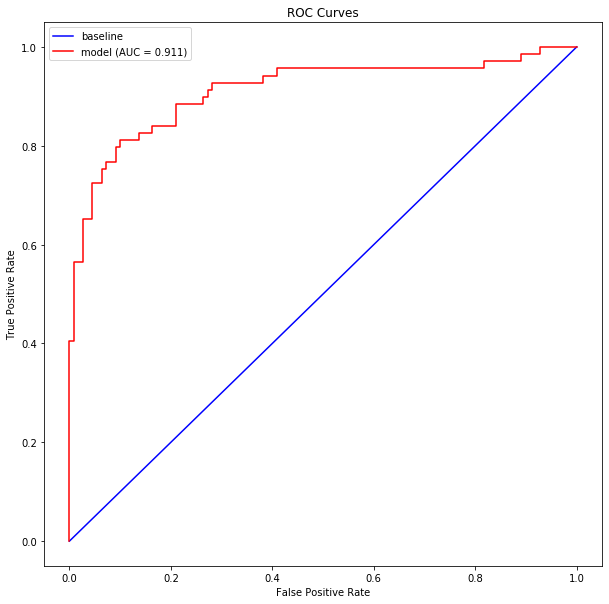

In [48]:
def plot_model_roc(predictions, probs, train_predictions, train_probs, test_labels):  
    
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)
    model_auc = np.round(roc_auc_score(test_labels, probs), 3)
    
    # Plot
    plt.figure(figsize = (10, 10))
    plt.plot([0, 1], [0, 1], 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model (AUC = {})'.format(model_auc))
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    print(f'AUC : {model_auc}')
    print(confusion_matrix(test_labels, rf_predictions))
    plt.show();

plot_model_roc(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs, cv_labels)

Comparing our score with the gender submission

In [49]:
print(f'Random Forest CV accuracy : {accuracy_score(cv_labels, rf_predictions)}')
print(f'Gender CV accuracy : {accuracy_score(cv_labels, 1-cv.Sex_male)}')

Random Forest CV accuracy : 0.8659217877094972
Gender CV accuracy : 0.7988826815642458


# Looking at Feature Importance & Permutation Importance

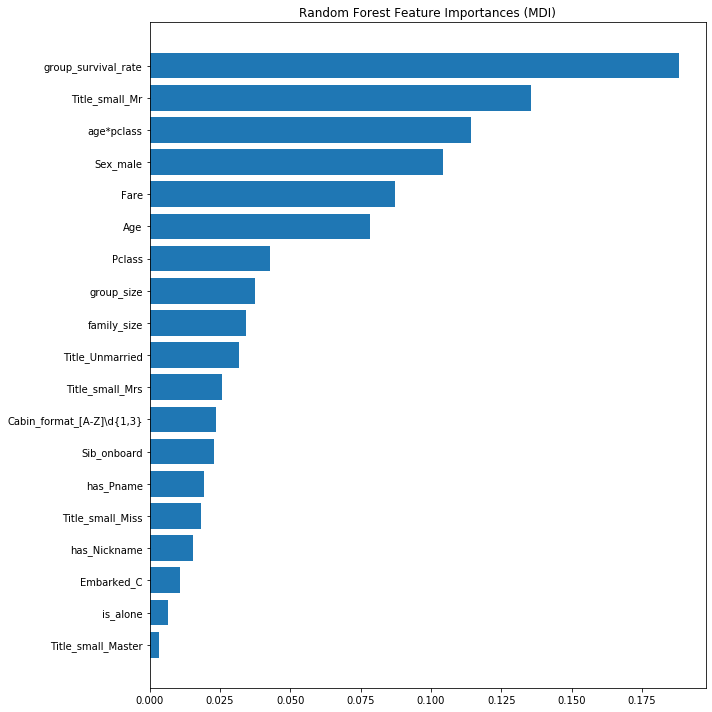

In [54]:
feature_names = np.r_[train_set.columns]
tree_feature_importances = model.feature_importances_
sorted_idx_rf = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(features))
fig, ax = plt.subplots(figsize = (10, 10))
# ax.figure(figsize = (16, 6))
ax.barh(y_ticks, tree_feature_importances[sorted_idx_rf])
ax.set_yticklabels(feature_names[sorted_idx_rf])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()

Using permutation importance can be better when there are both numerical and categorical features in the dataset, as the impurity-based feature importance can inflate the importance of numerical features (See [Permutation Importance vs Random Forest Feature Importance (MDI)](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html))

In [55]:
permutation_imp_data = permutation_importance(model, cv, cv_labels, n_repeats=10,
                                random_state=RSEED)
sorted_idx_pid = permutation_imp_data.importances_mean.argsort()

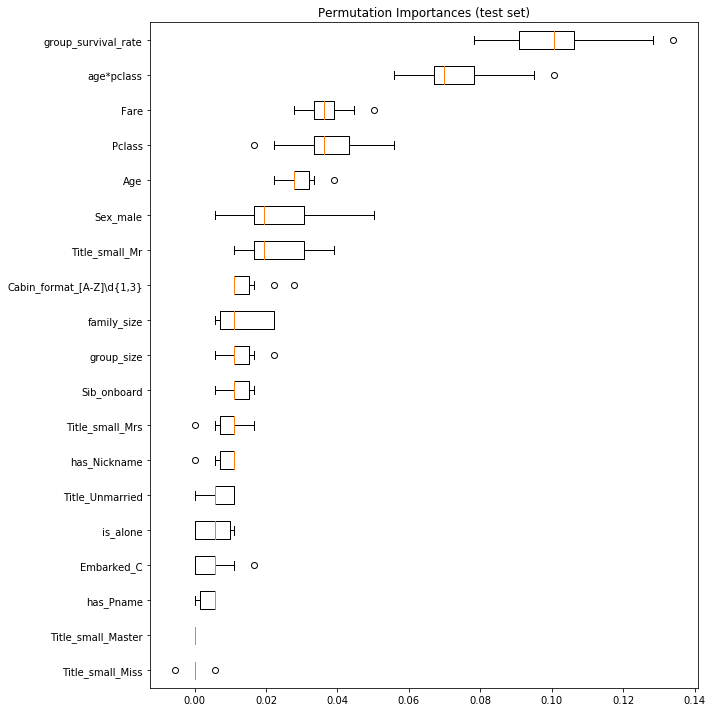

In [56]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.boxplot(permutation_imp_data.importances[sorted_idx_pid].T,
           vert=False, labels=cv.columns[sorted_idx_pid])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# Modeling - On Complete Train

In [57]:
# Fit on training data
model.fit(train_set, labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=66, verbose=0,
                       warm_start=False)

In [58]:
# Training predictions (to determine overfitting)
train_rf_predictions = model.predict(train_set)
train_rf_probs = model.predict_proba(train_set)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(test_set)
rf_probs = model.predict_proba(test_set)[:, 1]

In [59]:
prediction_set = test_set.copy()
prediction_set['Survived'] = rf_predictions
prediction_set = prediction_set[['Survived']]
prediction_set.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


Comparing our submission with the gender prediction as a sanity check. We don't expect too much variation.

In [61]:
confusion_matrix(prediction_set['Survived'], gender_submission['Survived'])

array([[244,  33],
       [ 22, 119]])

# Submitting result

In [25]:
# prediction_set.to_csv('submission_random_forest.csv')

evaluating our score as a percentile. 

The score to beat is: 0.79904
You beat the score!
Your percentile is: 96.67 %


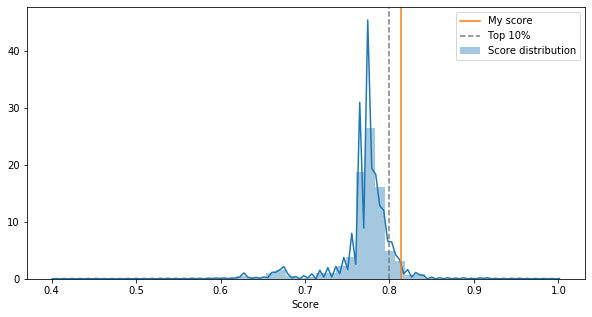

In [86]:
MY_BEST_SCORE = 0.81339
submissions = pd.read_csv('titanic-publicleaderboard.csv')
sub_max_scores = submissions.groupby('TeamId')['Score'].agg('max')
sub_max_scores = sub_max_scores[(sub_max_scores>0.4) & (sub_max_scores<1)]

score_to_beat = scoreatpercentile(sub_max_scores, 90)
print('The score to beat is:', score_to_beat)
print('You beat the score!' if score_to_beat < MY_BEST_SCORE else 'You didn''t beat the score...')
print('Your percentile is:', np.round(percentileofscore(sub_max_scores, MY_BEST_SCORE),2),'%')
ax = sns.distplot(sub_max_scores, label='Score distribution');
ax.axvline(MY_BEST_SCORE, color='C1', label='My score')
ax.axvline(score_to_beat, color='grey', linestyle='--', label='Top 10%')
plt.legend()
plt.show();